In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression # IMN Placeholder
# from sklearn.neural_network import MLPClassifier # Alternative IMN Placeholder (ensure it has predict_proba)
from sklearn.metrics import roc_auc_score # Changed from accuracy_score
from sklearn.preprocessing import LabelEncoder
# from sklearn.inspection import permutation_importance # Option for MLP importance

# --- Model Libraries ---
import catboost
from pytorch_tabnet.tab_model import TabNetClassifier
import shap

# --- Plotting ---
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression # IMN Placeholder
from sklearn.neural_network import MLPClassifier # Alternative IMN Placeholder
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance # Option for MLP importance

# --- Model Libraries ---
import catboost
from pytorch_tabnet.tab_model import TabNetClassifier
import shap

# --- Plotting ---
import matplotlib.pyplot as plt

# --- Helper Function for Normalizing Importances ---

In [ ]:
# --- Helper Function for Normalizing Importances (no changes needed here) ---
def get_ranked_features(importances, feature_names):
    """Returns feature names ranked by importance."""
    if importances is None:
        print("Warning: Received None for importances.")
        return []

    try:
        # Ensure importances is treated as a flat numpy array
        print(importances.shape)
        importances_flat = np.array(importances).flatten()
        print(importances_flat.shape)

        if len(importances_flat) == 0:
             print("Warning: Received empty importances.")
             return []
        if len(importances_flat) != len(feature_names):
             print(f"Warning: Mismatch between importances length ({len(importances_flat)}) and feature_names length ({len(feature_names)}).")
             return [] # Return empty for safety.

        abs_importances = np.abs(importances_flat)
        indices = np.argsort(abs_importances)[::-1]

        # Explicitly cast index 'i' to a standard Python int
        ranked_list = [feature_names[int(i)] for i in indices]
        return ranked_list

    except IndexError as e:
        print(f"Error during indexing in get_ranked_features: {e}")
        print(f"  Indices generated (first 10): {indices[:10]}")
        print(f"  Length of feature_names: {len(feature_names)}")
        return [] # Return empty list on error
    except Exception as e:
        print(f"An unexpected error occurred in get_ranked_features: {e}")
        print(f"  Importances type: {type(importances)}, Shape: {np.array(importances).shape if hasattr(importances, 'shape') else 'N/A'}")
        return [] # Return empty list on error


In [3]:
# --- Loading data ---

df = pd.read_csv("/home/athyrson/Code/Data/Processed Data/Lending Club/df_2010.csv")

X = df.drop(columns=['target'])
y = df['target']

# --- 2. Split Data ---
print("2. Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

2. Splitting data...


In [4]:


# Define preprocessing for numerical and categorical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Preprocessing for numerical data: Impute missing values and scale
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
]).set_output(transform='pandas')

# Preprocessing for categorical data: Impute missing values and apply target encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target', TargetEncoder())
]).set_output(transform='pandas')

# Combine preprocessors in a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
).set_output(transform='pandas')

# Apply preprocessing to the training and test data
X_train = preprocessor.fit_transform(X_train, y_train)
X_test = preprocessor.transform(X_test)

feature_names = X_train.columns.to_list()
feature_names

# Ensure y is integer encoded if needed by models like TabNet
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [ ]:
from sklearn.metrics import roc_auc_score

# --- Models and Importance Methods ---
models_to_evaluate = {
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "CatBoost": catboost.CatBoostClassifier(verbose=0, random_state=42),
    "TabNet": TabNetClassifier(verbose=0, seed=42),
    "IMN_Placeholder_LR": LogisticRegression(random_state=42, max_iter=1000),
}

# Store results: {method_name: [baseline_auc, {rank: auc_drop}]}
results = {}
top_n_features = 5

# --- 3 & 4. Train Base Models, Get Baseline AUC & Importances ---
print("\n3&4. Training base models, getting baseline AUC and importances...")

feature_importances = {}

for name, model in models_to_evaluate.items():
    print(f"  Processing: {name}")

    if name == "TabNet":
        model.fit(X_train.values, y_train,
                  eval_set=[(X_test.values, y_test)],
                  patience=10,
                  max_epochs=50)
        y_proba = model.predict_proba(X_test.values)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:, 1]

    baseline_auc = roc_auc_score(y_test, y_proba)
    results[name] = {'baseline_auc': baseline_auc, 'drops': {}}

    imps = None
    ranked_features = []
    if name == "DecisionTree":
        imps = model.feature_importances_
        ranked_features = get_ranked_features(imps, feature_names)
    elif name == "CatBoost":
        imps = model.get_feature_importance()
        ranked_features = get_ranked_features(imps, feature_names)
    elif name == "TabNet":
        imps = model.feature_importances_
        ranked_features = get_ranked_features(imps, feature_names)
    elif name == "IMN_Placeholder_LR":
        if hasattr(model, 'coef_'):
            imps = model.coef_[0]
            ranked_features = get_ranked_features(imps, feature_names)

    feature_importances[name] = ranked_features
    print(f"    Baseline AUC: {baseline_auc:.4f}")
    if ranked_features:
        print(f"    Top {top_n_features} Features: {ranked_features[:top_n_features]}")
    else:
        print(f"    Could not retrieve feature importances.")


# --- 4b. Calculate SHAP Importances (Example on Decision Tree) ---
print("\n4b. Calculating SHAP importances (on Decision Tree)...")
dt_model = models_to_evaluate["DecisionTree"]
explainer = shap.TreeExplainer(dt_model, X_train)
shap_values = explainer.shap_values(X_test, check_additivity=False)

if isinstance(shap_values, list):
    shap_sum = np.abs(shap_values[1]).mean(axis=0)
else:
    shap_sum = np.abs(shap_values).mean(axis=0)

print(shap_sum.shape)
print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
shap_ranked_features = get_ranked_features(shap_sum, feature_names)



feature_importances["SHAP (DecisionTree)"] = shap_ranked_features
results["SHAP (DecisionTree)"] = {'baseline_auc': results["DecisionTree"]['baseline_auc'], 'drops': {}}
print(f"    Top {top_n_features} SHAP Features: {shap_ranked_features[:top_n_features]}")


# --- 5 & 6. Iterative Feature Removal and Evaluation ---
print(f"\n5&6. Evaluating performance drop after removing top {top_n_features} features...")

all_methods = list(models_to_evaluate.keys()) + ["SHAP (DecisionTree)"]

for method_name in all_methods:
    print(f"  Processing removal analysis for: {method_name}")

    if method_name not in feature_importances or not feature_importances[method_name]:
        print(f"    Skipping {method_name} due to missing importance ranking.")
        continue

    ranked_features = feature_importances[method_name]
    baseline_auc = results[method_name]['baseline_auc']

    if "SHAP" in method_name:
        model_to_retrain = DecisionTreeClassifier(random_state=42)
    elif "IMN_Placeholder_LR" in method_name:
        model_to_retrain = LogisticRegression(random_state=42, max_iter=1000)
    elif "TabNet" in method_name:
        model_to_retrain = TabNetClassifier(verbose=0, seed=42)
    elif "CatBoost" in method_name:
        model_to_retrain = catboost.CatBoostClassifier(verbose=0, random_state=42)
    else:
        model_to_retrain = DecisionTreeClassifier(random_state=42)

    num_features_to_remove = min(top_n_features, len(ranked_features))

    for k in range(1, num_features_to_remove + 1):
        feature_to_remove = ranked_features[k-1]
        print(f"    Removing Top-{k} feature: {feature_to_remove}")

        X_train_reduced = X_train.drop(columns=[feature_to_remove], axis=1)
        X_test_reduced = X_test.drop(columns=[feature_to_remove], axis=1)

        if isinstance(model_to_retrain, TabNetClassifier):
            model_to_retrain.fit(X_train_reduced.values, y_train,
                                 eval_set=[(X_test_reduced.values, y_test)],
                                 patience=10, max_epochs=50)
            y_proba_reduced = model_to_retrain.predict_proba(X_test_reduced.values)[:, 1]
        else:
            model_to_retrain.fit(X_train_reduced, y_train)
            y_proba_reduced = model_to_retrain.predict_proba(X_test_reduced)[:, 1]

        auc_reduced = roc_auc_score(y_test, y_proba_reduced)
        auc_drop = baseline_auc - auc_reduced
        results[method_name]['drops'][k] = auc_drop
        print(f"      New AUC: {auc_reduced:.4f}, Drop: {auc_drop:.4f}")



3&4. Training base models, getting baseline AUC and importances...
  Processing: DecisionTree
[0.00786959 0.01396449 0.02284996 0.02536086 0.02445034 0.0240451
 0.01973762 0.05936665 0.04196602 0.00292422 0.01824544 0.01820489
 0.01978148 0.03052643 0.03161997 0.00448218 0.04081102 0.04429146
 0.03072436 0.         0.         0.01343308 0.22496849 0.
 0.         0.         0.         0.         0.00316926 0.
 0.02665053 0.02623508 0.02734551 0.01729943 0.03539846 0.04510104
 0.04926146 0.04991557 0.         0.         0.        ]
    Baseline AUC: 0.6179
    Top 5 Features: ['num__last_fico_range_low', 'num__annual_inc', 'cat__earliest_cr_line', 'cat__addr_state', 'cat__zip_code']
  Processing: CatBoost
[ 1.49248341  2.21769654  2.76006578  2.40266282  3.64199167  2.50833133
  1.782204    5.72655585  3.78264965  0.32909345  1.01812722  1.36812672
  2.97128774  2.7915485   2.7095017   0.21703688  3.39691203  3.5977956
  3.23185285  0.          0.         13.00184387 13.66681531  0.
  0

/home/athyrson/Code/py10/lib64/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[ 0.03577541  0.88572575 -1.1229649   0.33448609  0.37461285  0.29905406
  0.09836115 -0.25535193  0.01135608 -0.03178105  0.04760124  0.04760124
  0.19398152  0.02415678  0.02674159 -0.01698672  0.06134323 -0.01675987
  0.05412821  0.          0.         -1.31199949  0.05089618  0.
  0.          0.          0.          0.          0.07174886  0.
 -0.24854854 -1.74366527 -0.15968446 -0.39218519  3.16307811  0.38697469
  1.12673942 -0.06630184 -0.14602703 -0.14602703 -0.14602703]
    Baseline AUC: 0.8732
    Top 5 Features: ['cat__purpose', 'cat__sub_grade', 'num__last_fico_range_high', 'cat__addr_state', 'num__funded_amnt_inv']

4b. Calculating SHAP importances (on Decision Tree)...
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[0.00472072 0.00472072 0.00445951 0.00445951 0.02073784 0.02073784
 0.0303851  0.0303851  0.01084735 0.01084735 0.0228389  0.0228389
 0.00659965 0.00659965 0.02167119 0.02167119 0.00840217 0.00840217
 0.00065363 0.00065363 0.00494447 

/home/athyrson/Code/py10/lib64/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_auc = 0.86326


/home/athyrson/Code/py10/lib64/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


      New AUC: 0.8633, Drop: -0.0020
    Removing Top-3 feature: num__acc_now_delinq

Early stopping occurred at epoch 41 with best_epoch = 31 and best_val_0_auc = 0.86575


/home/athyrson/Code/py10/lib64/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


      New AUC: 0.8657, Drop: -0.0045
    Removing Top-4 feature: cat__earliest_cr_line

Early stopping occurred at epoch 45 with best_epoch = 35 and best_val_0_auc = 0.86496


/home/athyrson/Code/py10/lib64/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


      New AUC: 0.8650, Drop: -0.0037
    Removing Top-5 feature: num__last_fico_range_high

Early stopping occurred at epoch 45 with best_epoch = 35 and best_val_0_auc = 0.86245


/home/athyrson/Code/py10/lib64/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


      New AUC: 0.8625, Drop: -0.0012
  Processing removal analysis for: IMN_Placeholder_LR
    Removing Top-1 feature: cat__purpose
      New AUC: 0.8719, Drop: 0.0013
    Removing Top-2 feature: cat__sub_grade
      New AUC: 0.8728, Drop: 0.0004
    Removing Top-3 feature: num__last_fico_range_high
      New AUC: 0.8601, Drop: 0.0131
    Removing Top-4 feature: cat__addr_state
      New AUC: 0.8726, Drop: 0.0006
    Removing Top-5 feature: num__funded_amnt_inv
      New AUC: 0.8698, Drop: 0.0034
  Processing removal analysis for: SHAP (DecisionTree)
    Skipping SHAP (DecisionTree) due to missing importance ranking.


In [10]:
shap_sum.shape

(41, 2)


7. Summary of Accuracy Drops:

Method              | Rank | AUC Drop
--------------------|------|---------------
DecisionTree        |  1   | -0.0087
DecisionTree        |  2   | -0.0251
DecisionTree        |  3   | -0.0113
DecisionTree        |  4   | -0.0185
DecisionTree        |  5   | -0.0137
CatBoost            |  1   | -0.0004
CatBoost            |  2   | -0.0001
CatBoost            |  3   | -0.0004
CatBoost            |  4   | 0.0008
CatBoost            |  5   | 0.0012
TabNet              |  1   | 0.0027
TabNet              |  2   | -0.0020
TabNet              |  3   | -0.0045
TabNet              |  4   | -0.0037
TabNet              |  5   | -0.0012
IMN_Placeholder_LR  |  1   | 0.0013
IMN_Placeholder_LR  |  2   | 0.0004
IMN_Placeholder_LR  |  3   | 0.0131
IMN_Placeholder_LR  |  4   | 0.0006
IMN_Placeholder_LR  |  5   | 0.0034
SHAP (DecisionTree) |  -   | N/A


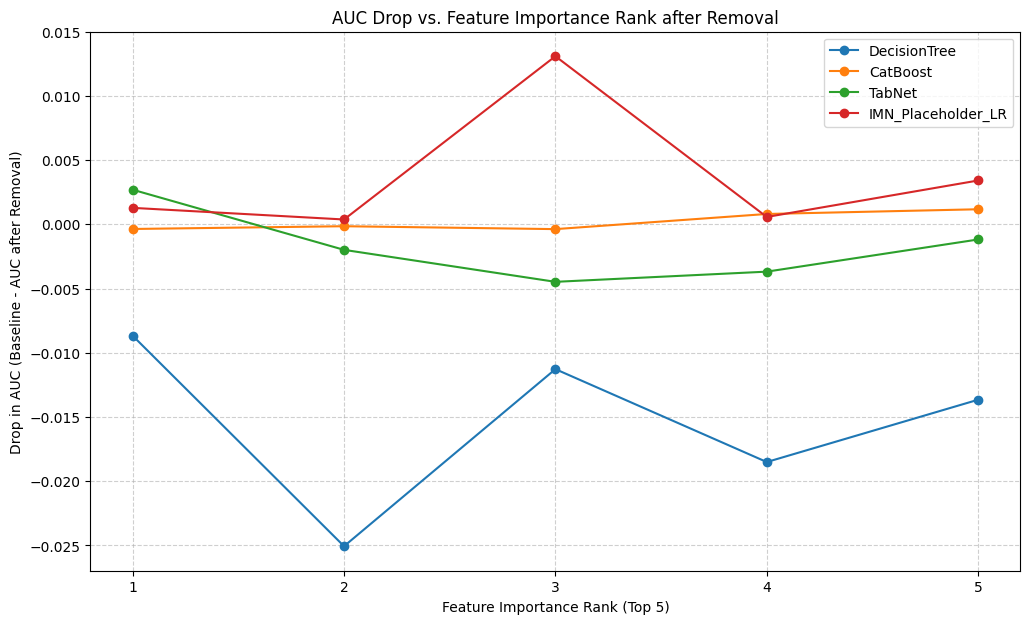


Analysis complete. Check the plot to visually compare the monotonicity of accuracy drop.


In [7]:
# --- 7. Analyze Results ---
print("\n7. Summary of Accuracy Drops:")

# Prepare data for plotting
plot_data = {}
ranks = list(range(1, top_n_features + 1))

print("\nMethod              | Rank | AUC Drop")
print("--------------------|------|---------------")
for method, data in results.items():
    if not data['drops']: # Handle cases where importance/drops weren't calculated
        print(f"{method:<20}|  -   | N/A")
        continue

    plot_data[method] = []
    for k in ranks:
       drop = data['drops'].get(k, np.nan) # Use NaN if rank wasn't processed
       plot_data[method].append(drop)
       print(f"{method:<20}|  {k}   | {drop:.4f}")


# --- Optional: Plotting the results (like Figure 6 description) ---
plt.figure(figsize=(12, 7))
for method, drops in plot_data.items():
    # Plot only if there are valid drop values
    valid_ranks = [r for r, d in zip(ranks, drops) if not np.isnan(d)]
    valid_drops = [d for d in drops if not np.isnan(d)]
    if valid_ranks:
       plt.plot(valid_ranks, valid_drops, marker='o', linestyle='-', label=method)

plt.xlabel(f"Feature Importance Rank (Top {top_n_features})")
plt.ylabel("Drop in AUC (Baseline - AUC after Removal)")
plt.title("AUC Drop vs. Feature Importance Rank after Removal")
plt.xticks(ranks)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

print("\nAnalysis complete. Check the plot to visually compare the monotonicity of accuracy drop.")